In [1]:
import sys
if "../src" not in sys.path:
    sys.path.append("../src")
    
import json
import pandas as pd
from pathlib import Path
from itertools import chain
from typing import cast, Dict
import subprocess
from praatio import textgrid
from weave import Speech, Utterance, Word, Character, Phone
from weave import BuildUtt

In [2]:
### Read charac-boundary dictionary
word_syll_map = pd.read_csv(Path("../data/mandarin_taiwan_mfa_retrovar.syll.tsv"), sep="\t")\
                  .groupby("ipa").first().drop("word", axis=1)\
                  .to_dict(orient="index")
word_syll_map = cast(Dict[str, Dict[str, str]], word_syll_map)

In [3]:
align_dir = Path("~/lago/mfa_data/aligned_vartest/CN_GY").expanduser()

mfa_tg_path = align_dir / Path("CN_GY_x.TextGrid")
fa = textgrid.openTextgrid(str(mfa_tg_path), False)
fa_words = fa.getTier("words")
fa_phones = fa.getTier("phones")
mfa_wlist = BuildUtt.build_words_phones(fa_words, fa_phones)  #type: ignore
mfa_words = BuildUtt.build_characters(mfa_wlist, word_syll_map)  #type: ignore
mfa_utt = Utterance.from_words(mfa_words)

In [4]:
def find_word(utt, word):
    for w in utt.words:
        if w.label == word:
            return w
    return None
find_word(mfa_utt, "尊重")

<Word: [5.42-6.12] 尊重>
 <Character: [5.42-5.74] 尊>
  <Phone: [5.42-5.52] ʈʂ>
  <Phone: [5.52-5.53] w>
  <Phone: [5.53-5.59] ə˥˥>
  <Phone: [5.59-5.74] n>
 <Character: [5.74-6.12] 重>
  <Phone: [5.74-5.88] ts>
  <Phone: [5.88-5.95] u˥˩>
  <Phone: [5.95-6.12] ŋ>

In [14]:
import kaldiio

mfa_dir = Path("~/Documents/MFA/vartest/").expanduser()
gmm_ark_path = mfa_dir / "alignment/gmmlik.1.1.ark"
d = kaldiio.load_ark(str(gmm_ark_path))

for key, gmmlik in d:
    ...

In [17]:
from weave import MfaAgent
# note: there should be a final.mdl.txt; if not, run
# gmm-copy --binary=false final.mdl final.mdl.txt
agent = MfaAgent(str(mfa_dir), "vartest")

In [13]:
gmmlik.shape, mfa_utt.end-mfa_utt.start

((1047, 5976), 10.490204)

In [24]:
tm = agent.tmodel
am = agent.tmodel.am
len(tm.triples), max(x[2] for x in tm.triples)

(91361, 5975)

In [30]:
pid2phone = [0]*len(agent.phones)
for phone_x, pid_x in agent.phones.items():
    pid2phone[pid_x] = phone_x

In [61]:
import re
def extract_phone(x):
    x = x.split("_")[0]
    x = re.sub("[\u02e5-\u02e9]+", "", x)
    return x

phone2pdfid = {}
pdfid2phone = {}
for triple_x in tm.triples:
  phone_id, hmm_state, pdf_id = triple_x
  phone = extract_phone(pid2phone[phone_id])
  phone = extract_phone(phone)
  phone2pdfid.setdefault(phone, []).append(pdf_id)
  pdfid2phone.setdefault(pdf_id, []).append(phone)

In [62]:
# softmax over gmmlik's second dimension
import numpy as np
gmmprob = np.exp(gmmlik) / np.sum(np.exp(gmmlik), axis=1, keepdims=True)

In [63]:
retro_ids = phone2pdfid["ʈʂ"]
nonretro_ids = phone2pdfid["ts"]
retro_prob = gmmprob[:, retro_ids].mean(axis=1)
nonretro_prob = gmmprob[:, nonretro_ids].mean(axis=1)

In [ ]:
np.linspace()

In [69]:
np.linspace(0, (step_start-step_end+1), 10)

array([  0.        ,  -7.66666667, -15.33333333, -23.        ,
       -30.66666667, -38.33333333, -46.        , -53.66666667,
       -61.33333333, -69.        ])

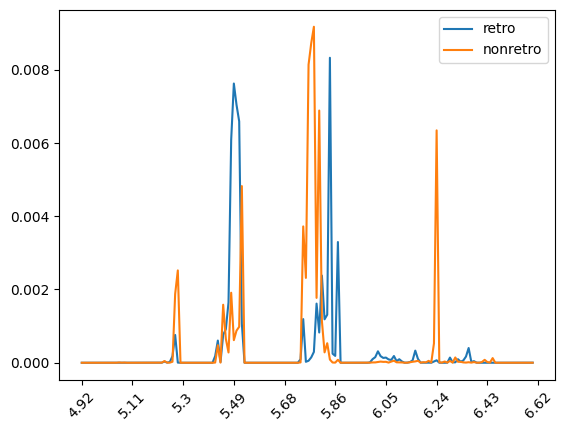

In [73]:
import matplotlib.pyplot as plt
tgt_start = 4.92
tgt_end = 6.62
step_start = int(tgt_start//0.01)
step_end = int(tgt_end//0.01)
plt.xticks(np.linspace(0, (step_end-step_start+1), 10), 
           np.round(np.linspace(tgt_start, tgt_end, 10),2), rotation=45)
plt.plot(retro_prob[step_start:step_end], label="retro")
plt.plot(nonretro_prob[step_start:step_end], label="nonretro")
plt.legend()

In [74]:
find_word(mfa_utt, "尊重")

<Word: [5.42-6.12] 尊重>
 <Character: [5.42-5.74] 尊>
  <Phone: [5.42-5.52] ʈʂ>
  <Phone: [5.52-5.53] w>
  <Phone: [5.53-5.59] ə˥˥>
  <Phone: [5.59-5.74] n>
 <Character: [5.74-6.12] 重>
  <Phone: [5.74-5.88] ts>
  <Phone: [5.88-5.95] u˥˩>
  <Phone: [5.95-6.12] ŋ>

## Sandbox

In [ ]:
## Show the pdf_id having multiple phones

for pdfid, phones in pdfid2phone.items():
    phone_type = set(extract_phone(phone_x) for phone_x in phones)

    if len(phone_type) > 1:
        print(pdfid, phone_type)